In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import mysql.connector as mariadb
import pandas as pd
import numpy as np
from gatspy import periodic
from astropy.time import Time

In [2]:
# Connect to database
con = mariadb.connect(user='ztf', database='ztf')

In [ ]:
# Read alerts for solar system objects from after the photometry fix 
sso_alert_fix_date1 = Time('2018-05-16T23:30:00', format='isot', scale='utc') # first attribution fix
sso_alert_fix_date2 = Time('2018-06-08T23:30:00', format='isot', scale='utc') # second attribution fix
sso_alert_phot_fix_date = Time('2018-06-18T23:30:00', format='isot', scale='utc') # photometry fix date

jd_good = sso_alert_phot_fix_date.jd
print(jd_good)
df = pd.read_sql_query('select * from alerts where ssdistnr >= 0 and jd > %f' % jd_good, con)
print(len(df))

2458288.4791666665


In [4]:
# Add more easily readable date of observation
obsdate = Time(df['jd'], format='jd', scale='tai')
df['obsdate'] = obsdate.isot
df.obsdate.min(), df.obsdate.max()

('2018-06-19T04:17:25.002', '2018-10-09T06:51:28.999')

In [5]:
ssnamenr = df["ssnamenr"].unique()

In [6]:
len(ssnamenr)

90104

In [7]:
test = df[(df["ssnamenr"] == "6564") & (df["fid"] == 2)]

In [8]:
jd = test["jd"]
magpsf = test["magpsf"]
magerr = test["sigmapsf"]

<ErrorbarContainer object of 3 artists>

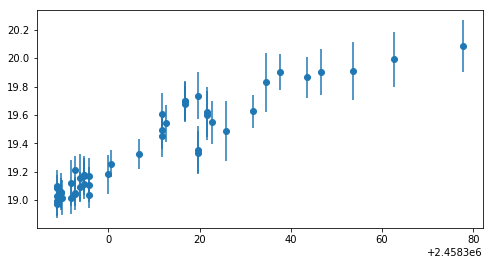

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.errorbar(jd, magpsf, yerr=magerr, fmt="o", markersize=6)

In [10]:
df.shape

(628667, 101)

## Jupiter Trojan Data

Let's look at the jupiter trojans:

In [11]:
trojans = pd.read_csv("Jupiter_Trojans.csv")

In [12]:
df.shape

(628667, 101)

In [13]:
trojans.head()

,pdes,a,e,i,om,w,ma,q,ad,per_y,...,rot_per,BV.1,UB.1,IR.1,spec_B.1,spec_T,rot_per.1,spec_T.1,GM,full_name
0,588,5.209480,0.146566,10.319119,316.535502,133.358901,238.460899,4.445950,5.973010,11.890490,...,7.3060,0.755,0.216,NaN,NaN,DU,7.3060,DU,NaN,588 Achilles (1906 TG)
1,617,5.215835,0.138432,22.048300,44.351808,307.949138,203.758200,4.493797,5.937873,11.912254,...,102.8000,0.677,0.215,NaN,NaN,P,102.8000,P,NaN,617 Patroclus (1906 VY)
2,624,5.259580,0.023280,18.162460,342.793774,185.152904,168.887663,5.137134,5.382025,12.062429,...,6.9240,0.776,0.249,NaN,NaN,D,6.9240,D,NaN,624 Hektor (1907 XM)
3,659,5.166168,0.117711,4.521961,350.743623,343.198498,341.519469,4.558053,5.774282,11.742510,...,15.9800,0.719,0.249,NaN,NaN,XC,15.9800,XC,NaN,659 Nestor (1908 CS)
4,884,5.181758,0.122676,8.915379,301.562953,335.474162,291.306129,4.546079,5.817436,11.795704,...,6.8605,0.718,0.229,NaN,NaN,D,6.8605,D,NaN,884 Priamus (1917 CQ)


In [14]:
trojan_data = pd.merge(df, trojans, left_on="ssnamenr", right_on="pdes")

In [15]:
trojan_data.shape

(6937, 136)

In [16]:
len(trojan_data["ssnamenr"].unique())

532

In [40]:
nobs = trojan_data.groupby("ssnamenr").apply(len)

In [41]:
mask = (nobs.values > 100)

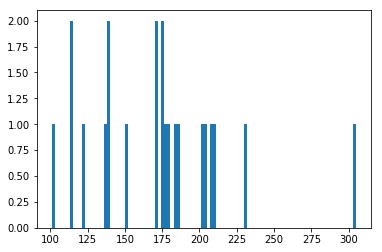

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(nobs[mask], bins=100, histtype="stepfilled");

In [44]:
len(nobs[mask])

22

In [21]:
rot_per = trojans["rot_per.1"]

In [22]:
rot_per = rot_per[np.isfinite(rot_per)]

(0, 100)

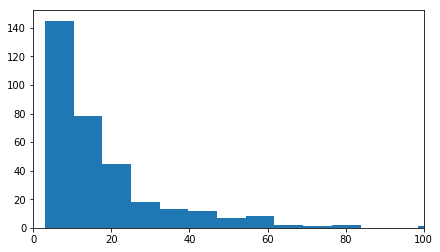

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.hist(rot_per, histtype="stepfilled", bins=100);

ax.set_xlim(0, 100)

Let's look at Trojan with the largest number of data points:

In [24]:
nobs[nobs == nobs.max()]

ssnamenr
65245    305
dtype: int64

In [25]:
ssname = '65245'

In [26]:
troj = trojan_data[trojan_data["ssnamenr"] == ssname]

In [27]:
fid = troj["fid"]
jd = troj["jd"] - troj["jd"].min()
magpsf = troj["magpsf"]
sigmapsf = troj["sigmapsf"]
magcorr = troj["magpsf"] - troj["ssmagnr"]

In [28]:
fid[fid == 1].index

Int64Index([5164, 5171, 5173, 5177, 5179], dtype='int64')

In [29]:
np.unique(fid)

array([1, 2])

1
2


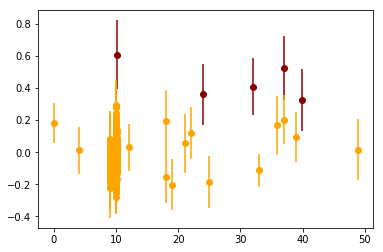

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

colours = ["darkblue", "darkred", "orange"]
for i in np.unique(fid):
    print(i)
    mask = fid[fid == i].index
    ax.errorbar(jd.loc[mask], magcorr.loc[mask], yerr=sigmapsf.loc[mask], fmt="o", color=colours[i])
    
#ax.set_xlim(8.9,10.5)

In [31]:
mask = fid[fid == 2].index
jd2 = jd[mask]
magcorr2 = magcorr[mask]
sigmapsf2 = sigmapsf[mask]

In [32]:
np.savetxt("65245_ztf.txt", np.array([jd2, magcorr2, sigmapsf2]).T)

What about the other ones with more than a hundred data points?

In [39]:
mask

Int64Index([4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885,
            ...
            5167, 5168, 5169, 5170, 5172, 5174, 5175, 5176, 5178, 5180],
           dtype='int64', length=300)

In [46]:
trojan_ids = nobs[mask].index

In [ ]:
for i,tr in enumerate(trojan_ids):
    troj = trojan_data[trojan_data["ssnamenr"] == tr]
    fid = np.array(troj["fid"])
    jd = np.array(troj["jd"])
    magpsf = np.array(troj["magpsf"])
    sigmapsf = np.array(troj["sigmapsf"])
    magcorr = np.array(troj["magpsf"] - troj["ssmagnr"])
    
    np.savetxt("%s_ztf_lc.txt"%tr, 
               np.array([jd, magpsf, magcorr, sigmapsf, fid]).T)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.errorbar(jd, magpsf, yerr=sigmapsf, fmt="o", markersize=8, color="black")
    ax.set_xlabel("MJD")
    ax.set_ylabel("r-band magnitude")
    
    ax.set_title("asteroid ID: " + str(tr))
    
    plt.savefig("%s_ztf_lc.pdf"%tr, format="pdf")
    plt.close()

In [171]:
#import pymc3 as pm
from astropy.stats import LombScargle
from gatspy import periodic

In [70]:
g = trojan_data.groupby('ssnamenr')
nights = trojan_data.groupby('nid')
print(len(g), len(nights))

532 102


In [5]:
g = df.groupby('ssnamenr')
nights = df.groupby('nid')
print(len(g), len(nights))

90104 105


In [6]:
# Pull out the list of objects with many observations, within @cutoff of the attributed sso.
cutoff = 10
large_obs = df.query('ssdistnr < @cutoff').groupby('ssnamenr')[['jd']].count().query('jd > 40')
names = large_obs.sort_values('jd', ascending=False)
objnames = names.index.values
len(names)

811

In [49]:
def phase_times(times, period, offset=0):
    phased = (times - offset) % period 
    phased = phased / period
    return phased

In [50]:
filterdict = {1: 'g', 2: 'r', 3: 'i'}
filterdict_inv = {'g': 1, 'r': 2, 'i': 3}
# Pull out observations of an object.
def get_obs(name, minJD=None, maxJD=None):
    obj = df.query('ssnamenr == @name')
    if minJD is not None:
        obj = obj.query('jd > @minJD')
    if maxJD is not None:
        obj = obj.query('jd < @maxJD')
    # Add the 'corrected' magnitude values
    magcorr = obj.magpsf.values - obj.ssmagnr.values
    obj['magcorr'] = magcorr
    # And pull out the observations in each filter. 
    filterlist = obj.fid.unique()
    o = {}
    for f in filterlist:
        o[f] = obj.query('fid == @f')
        print('Filter %s (%s) has %d observations' % (f, filterdict[f], len(o[f])))
    obj.to_csv(name + '.csv')
    return obj, o

In [51]:
def check_astrometry(obj):
    # Check astrometry residuals?
    plt.figure(figsize=(8, 8))
    plt.plot(obj.jd, obj.ssdistnr, 'k.')
    plt.figtext(0.2, 0.8, 'Nobs = %d' % (len(obj)))
    plt.xlabel('JD', fontsize='x-large')
    plt.ylabel('ssdistnr (arcsec)', fontsize='x-large')
    plt.title(name)

In [52]:
def vis_photometry(obj, o, fulldates=False):
    # Look at photometry
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for f in o:
        if fulldates:
            times = o[f].jd
        else:
            times = o[f].jd - obj.jd.iloc[0]
        plt.errorbar(times, o[f].magap, yerr=o[f].sigmagap, color=filterdict[f], 
                     marker='.', linestyle='')
    if fulldates:
        times = obj.jd
    else:
        times = obj.jd - obj.jd.iloc[0]
    plt.plot(times, obj.ssmagnr)
    plt.figtext(0.15, 0.8, 'Nobs = %d, Nnights = %d' % (len(obj), len(obj.nid.unique())))
    plt.xticks(rotation=90)
    if fulldates:
        plt.xlabel('JD', fontsize='x-large')
    else:
        plt.xlabel('Delta JD', fontsize='x-large')
    plt.ylabel('ApMag', fontsize='x-large')
    plt.title(name)
    plt.subplot(1, 2, 2)
    for f in o:
        if fulldates:
            times = o[f].jd
        else:
            times = o[f].jd - obj.jd.iloc[0]
        plt.errorbar(times, o[f].magpsf, yerr=o[f].sigmapsf, color=filterdict[f], 
                     marker='.', linestyle='')
    if fulldates:
        times = obj.jd
    else:
        times = obj.jd - obj.jd.iloc[0]
    plt.plot(times, obj.ssmagnr)
    plt.figtext(0.58, 0.8, 'Nobs = %d, Nnights = %d' % (len(obj), len(obj.nid.unique())))
    plt.xticks(rotation=90)
    if fulldates:
        plt.xlabel('JD', fontsize='x-large')
    else:
        plt.xlabel('Delta JD', fontsize='x-large')
    plt.ylabel('PSF mag', fontsize='x-large')
    plt.title(name)
    if '1' in o and '2' in o:
        objgr = o[filterdict_inv['g']].magpsf.mean() - o[filterdict_inv['r']].magpsf.mean()
        print('Average colors (g-r) %.2f' % (objgr))
    return fig

In [53]:
def vis_corr_photometry(obj, o):
    # Look at photometry after subtracting expected magnitude 
    # (i.e. subtract an approximate phase curve, but the ZTF predicted values do have errors sometimes)
    fig = plt.figure(figsize=(8, 6))
    for f in o:
        plt.errorbar(o[f].jd - obj.jd.iloc[0], o[f].magcorr, yerr=o[f].sigmapsf, color=filterdict[f], 
                     marker='.', linestyle='')
    plt.figtext(0.15, 0.8, 'Nobs = %d, Nnights = %d' % (len(obj), len(obj.nid.unique())))
    plt.xticks(rotation=90)
    plt.xlabel('delta JD', fontsize='x-large')
    plt.ylabel('MagCorr (magpsf - ssmagnr)', fontsize='x-large')
    plt.title(name)
    plt.grid(True, alpha=0.3)
    if '1' in o and '2' in o:
        objgr = o[filterdict_inv['g']].magcorr.mean() - o[filterdict_inv['r']].magcorr.mean()
        print('Average magcorr colors (g-r) %.2f' % (objgr))
    return fig

In [54]:
def fit_model(obj, periodogram=True):
    # Let's try to fit these values with the gatspy multiband fitter
    model = periodic.LombScargleMultiband(fit_period=True, Nterms_base=2, Nterms_band=1)
    model.optimizer.period_range = (2.0/24.0, 2.0)
    model.optimizer.first_pass_coverage = 100
    model.fit(obj.jd, obj.magcorr, obj.sigmapsf, obj.fid)
    top_periods = model.find_best_periods()
    print('Top Periods (and doubles):')
    print(' '.join(['%.3f (%.3f) hours\n' % (p*24.0, p*24.0*2) for p in top_periods if p < 1]), 
          ' '.join(['%.3f (%.3f) days\n' % (p, p*2) for p in top_periods if p > 1]))
    print()
    print('Best fit period: %.3f hours' % (model.best_period * 24))
    if periodogram:
        # Look at the periodogram
        periods, power = model.periodogram_auto(oversampling=100, nyquist_factor=5)
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.plot(periods, power)
        for p in top_periods:
            plt.axvline(p, color='k', linestyle=':')
        plt.xlabel('Period (days)')
        plt.ylabel('Power')
        plt.xlim(0, 3)
        plt.subplot(1, 2, 2)
        plt.plot(periods * 24, power)
        for p in top_periods:
            plt.axvline(p*24, color='k', linestyle=':')
        plt.xlabel('Period (hours)')
        plt.ylabel('Power')
        plt.xlim(2, 12)
    else:
        fig = None
    return model, top_periods, model.best_period, fig

In [55]:
def make_predictions(obj, period, model):
    # Generate predicted data, using one of the periods.
    tfit = np.arange(obj.jd.min(), obj.jd.max(), 0.02)
    filts = np.ones(len(tfit))
    pred = model.predict(tfit, filts=filts, period=period)
    pred2 = model.predict(tfit, filts=filts+1, period=period)
    return tfit, pred, pred2

In [56]:
def plot_unphased(obj, o, period, model, name):
    # I'm not sure wth is going on with the predicted values here ... 
    fig = plt.figure(figsize=(10, 8))
    tfit, pred, pred2 = make_predictions(obj, period, model)
    plt.plot(tfit, pred, color=filterdict[1], linestyle=':', alpha=0.2)
    plt.plot(tfit, pred2, color=filterdict[2], linestyle=':', alpha=0.2)
    for f in o:
        mag = o[f].magcorr
        if f == filterdict_inv['r']:
            mag = mag #+ objgr
        plt.errorbar(o[f].jd, mag, yerr=o[f].sigmapsf, color=filterdict[f], 
                     marker='.', linestyle='')

    objgr = np.mean(pred2 - pred)
    objgr_2 = np.mean(o[filterdict_inv['g']].magcorr) - np.mean(o[filterdict_inv['r']].magcorr)
    plt.figtext(0.15, 0.8, 'Nobs = %d, Nnights = %d\n Period %.2f hours \n Mean object color %.2f (%.2f)' 
                % (len(obj), len(obj.nid.unique()), period * 24., objgr, objgr_2))
    plt.xlabel('JD', fontsize='x-large')
    plt.ylabel('magcorr', fontsize='x-large')
    plt.title(name)
    return fig

In [57]:
def plot_phased(obj, o, period, model, name):
    # Phased
    tfit = np.arange(0, period, 0.002)
    filts = np.ones(len(tfit))
    pred = model.predict(tfit, filts=filts, period=period)
    pred2 = model.predict(tfit, filts=filts+1, period=period)

    fig = plt.figure(figsize=(10, 8))
    plt.plot(phase_times(tfit, period), pred, color=filterdict[1], linestyle=':')
    plt.plot(phase_times(tfit, period), pred2, color=filterdict[2], linestyle=':')

    for f in o:
        mag = o[f].magcorr
        if f == filterdict_inv['r']:
            mag = mag 
        plt.errorbar(phase_times(o[f].jd, period), mag, yerr=o[f].sigmapsf, color=filterdict[f], 
                     marker='.', linestyle='')

    objgr = np.mean(pred2 - pred)
    objgr_2 = np.mean(o[filterdict_inv['g']].magcorr) - np.mean(o[filterdict_inv['r']].magcorr)
    plt.figtext(0.15, 0.8, 'Nobs = %d, Nnights = %d\n Period %.2f hours \n Mean object color %.2f (%.2f)' 
                % (len(obj), len(obj.nid.unique()), period * 24., objgr, objgr_2))
    plt.xlabel('Phase', fontsize='x-large')
    plt.ylabel('magcorr', fontsize='x-large')
    plt.title(name)
    plt.grid(True, alpha=0.3)
    return fig

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Filter 1 (g) has 57 observations
Filter 2 (r) has 254 observations


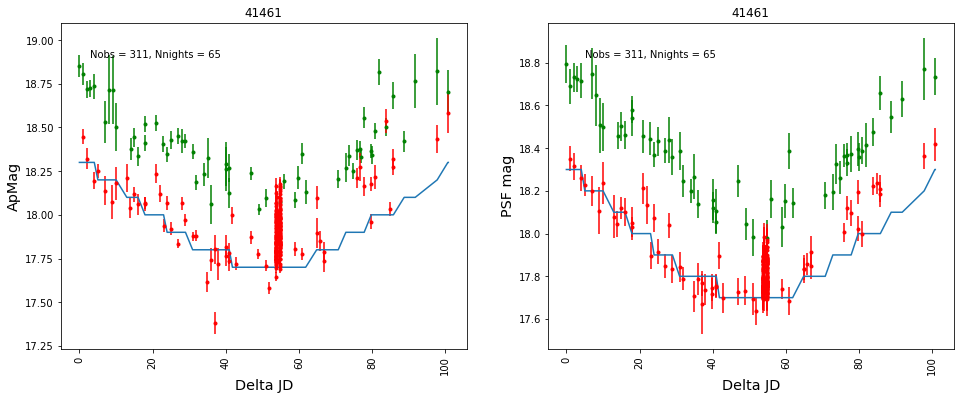

In [58]:
name = '41461'
obj, o = get_obs(name)
vis_photometry(obj, o, fulldates=False).savefig(name + '_full.png')

In [59]:
top_periods = {}
best_periods = {}
models = {}
periodograms = {}
phasefigures = {}
for n in ['41461']:
    print('Working on %s' % n)
    # Pick an object in list:
    obj, o = get_obs(n)
    models[n], top_periods[n], best_periods[n], periodograms[n] = fit_model(obj, periodogram=True)
    phasefigures[n] = plot_phased(obj, o, best_periods[n], models[n], n)

Working on 41461
Filter 1 (g) has 57 observations
Filter 2 (r) has 254 observations
Finding optimal frequency:
 - Estimated peak width = 0.0623
 - Using 100 steps per peak; omega_step = 0.000623
 - User-specified period range:  0.083 to 2
 - Computing periods at 115940 steps


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Zooming-in on 5 candidate peaks:
 - Computing periods at 45 steps
Finding optimal frequency:
 - Estimated peak width = 0.0623
 - Using 100 steps per peak; omega_step = 0.000623
 - User-specified period range:  0.083 to 2
 - Computing periods at 115940 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 90 steps
Top Periods (and doubles):
6.031 (12.062) hours
 4.817 (9.634) hours
 3.016 (6.031) hours
 2.678 (5.356) hours
 3.451 (6.901) hours
 

Best fit period: 6.031 hours


KeyboardInterrupt: 

In [56]:
#print(objnames)
print(len(objnames))

811


Working on 7075
Filter 2 (r) has 423 observations
Filter 1 (g) has 9 observations


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Finding optimal frequency:
 - Estimated peak width = 0.143
 - Using 100 steps per peak; omega_step = 0.00143
 - User-specified period range:  0.083 to 2
 - Computing periods at 50480 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 50 steps
Finding optimal frequency:
 - Estimated peak width = 0.143
 - Using 100 steps per peak; omega_step = 0.00143
 - User-specified period range:  0.083 to 2
 - Computing periods at 50480 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 100 steps
Top Periods (and doubles):
14.602 (29.204) hours
 21.018 (42.037) hours
 10.504 (21.007) hours
 10.261 (20.521) hours
 1.557 (3.114) days


Best fit period: 14.602 hours
Working on 68476
Filter 2 (r) has 391 observations
Filter 1 (g) has 10 observations
Finding optimal frequency:
 - Estimated peak width = 0.15
 - Using 100 steps per peak; omega_step = 0.0015
 - User-specified period range:  0.083 to 2
 - Computing periods at 48302 steps
Zooming-in on 5 candidate peaks:
 - Computing p

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working on 2007UJ07
Filter 2 (r) has 161 observations
Filter 1 (g) has 114 observations
Filter 3 (i) has 2 observations
Finding optimal frequency:
 - Estimated peak width = 0.0723
 - Using 100 steps per peak; omega_step = 0.000723
 - User-specified period range:  0.083 to 2
 - Computing periods at 99904 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 45 steps
Finding optimal frequency:
 - Estimated peak width = 0.0723
 - Using 100 steps per peak; omega_step = 0.000723
 - User-specified period range:  0.083 to 2
 - Computing periods at 99904 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 90 steps
Top Periods (and doubles):
20.775 (41.551) hours
 12.963 (25.925) hours
 1.178 (2.356) days
 1.080 (2.160) days
 1.731 (3.462) days


Best fit period: 28.272 hours


ValueError: Invalid RGBA argument: 'i'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd6670bc268> (for post_execute):


ValueError: Invalid RGBA argument: 'i'

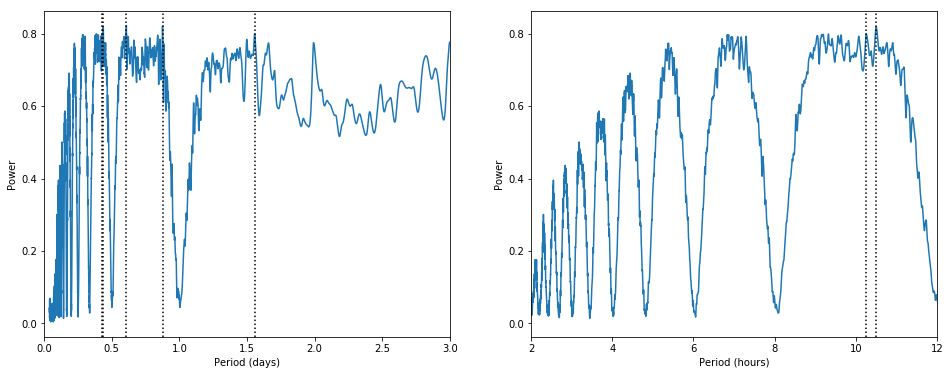

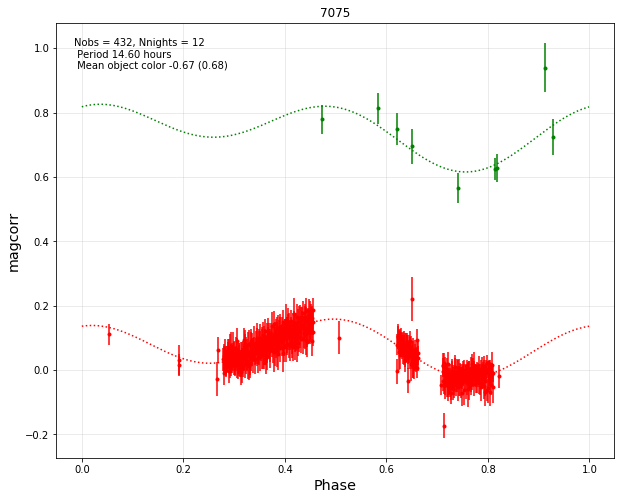

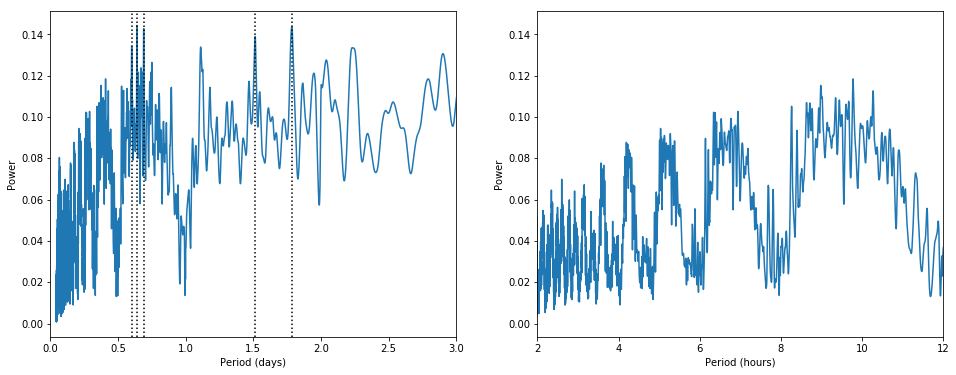

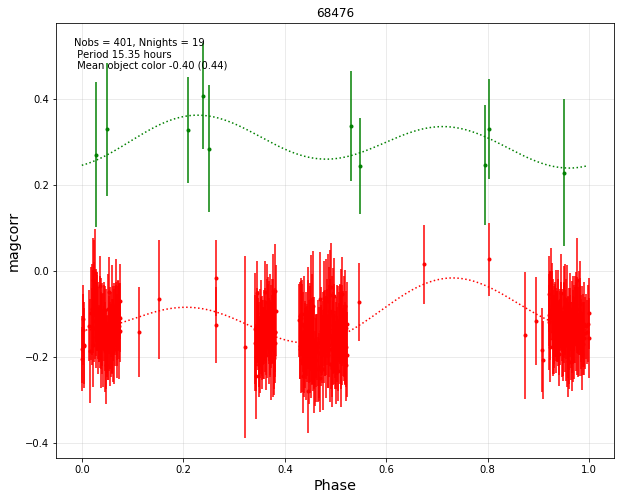

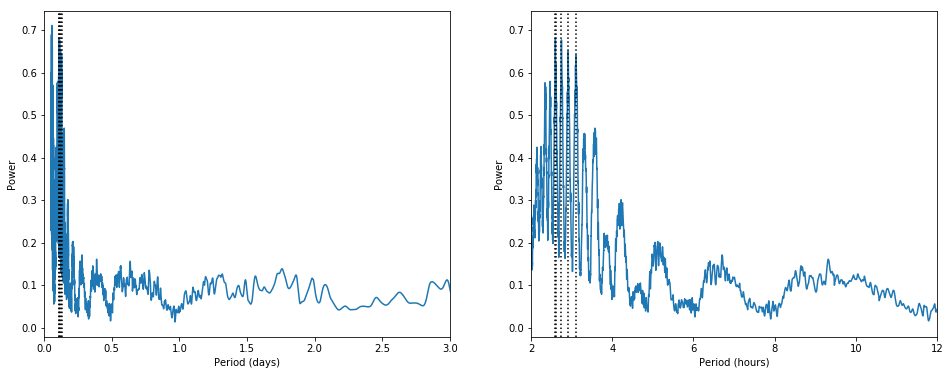

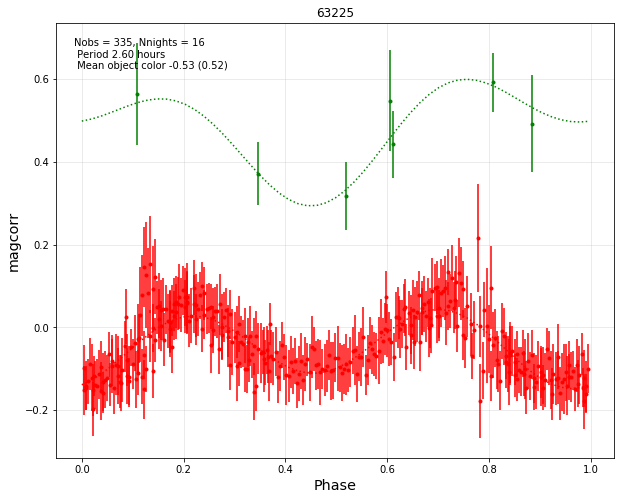

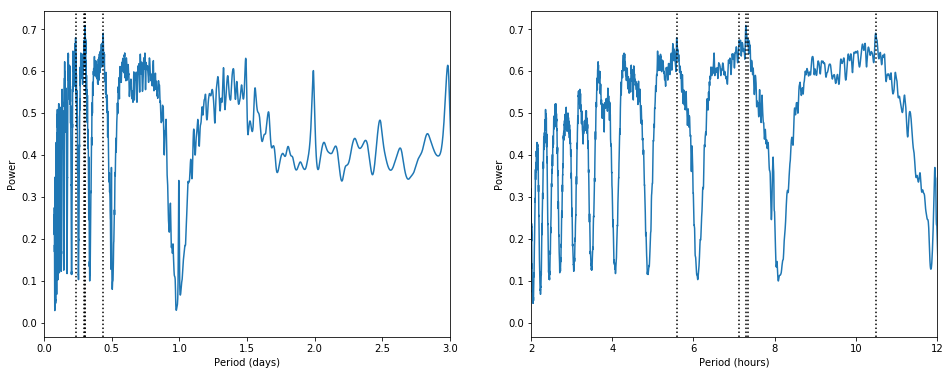

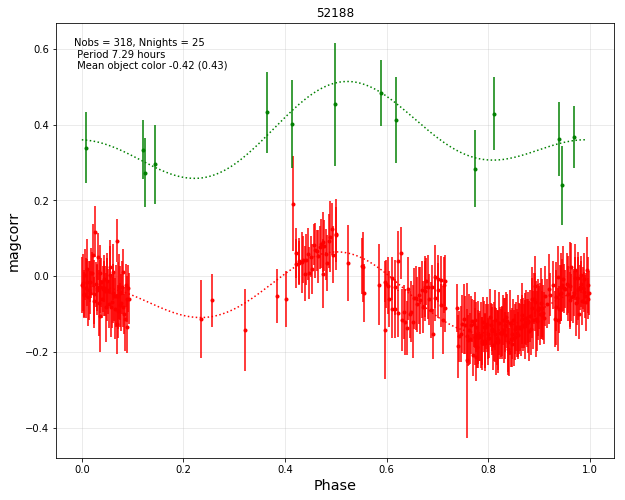

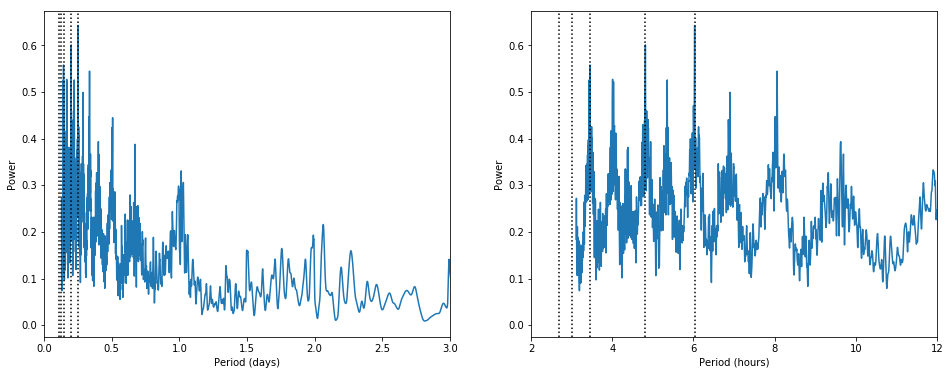

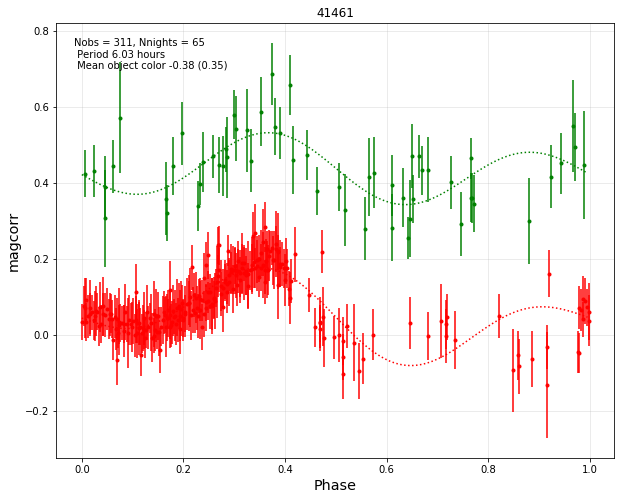

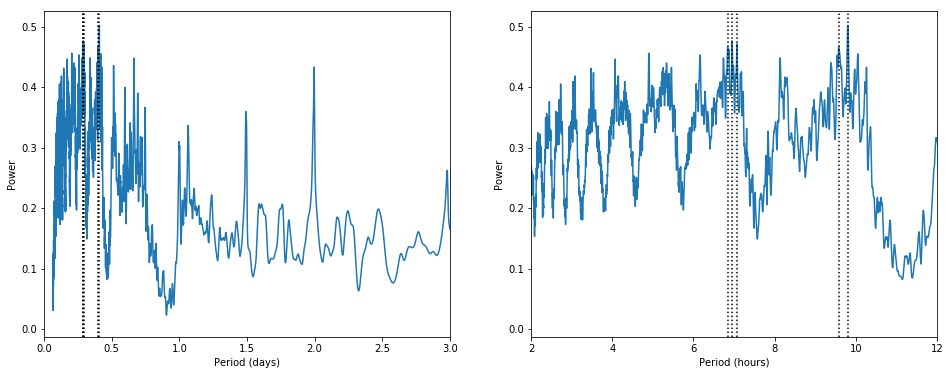

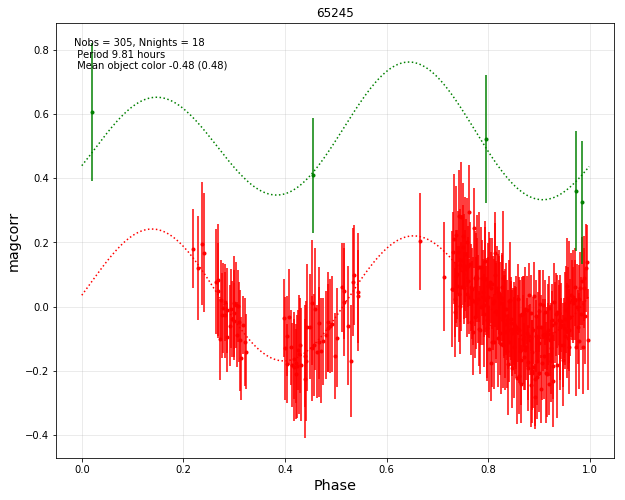

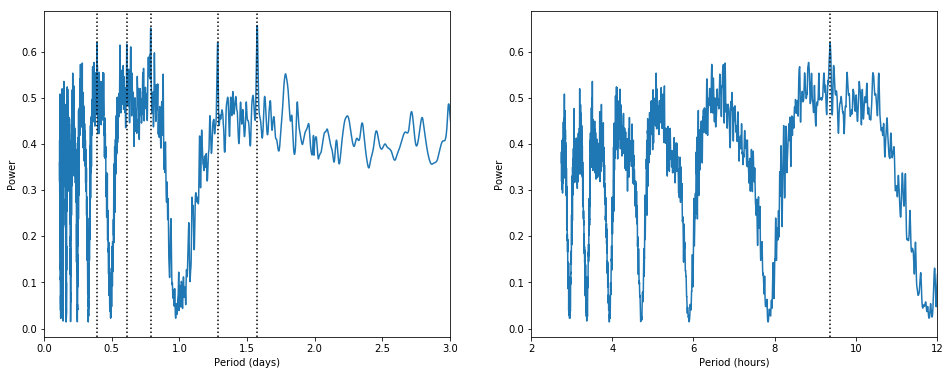

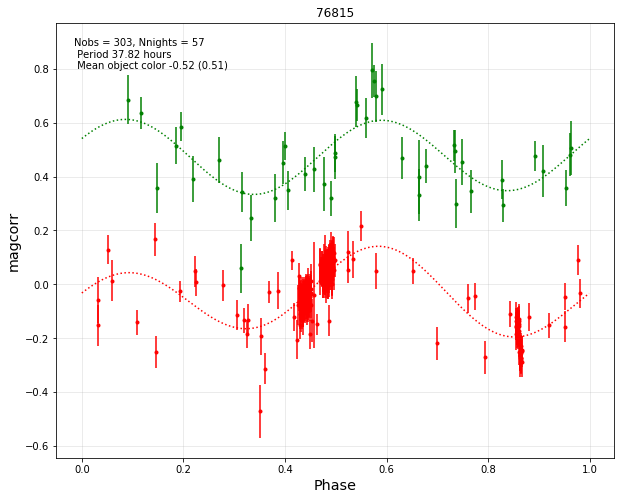

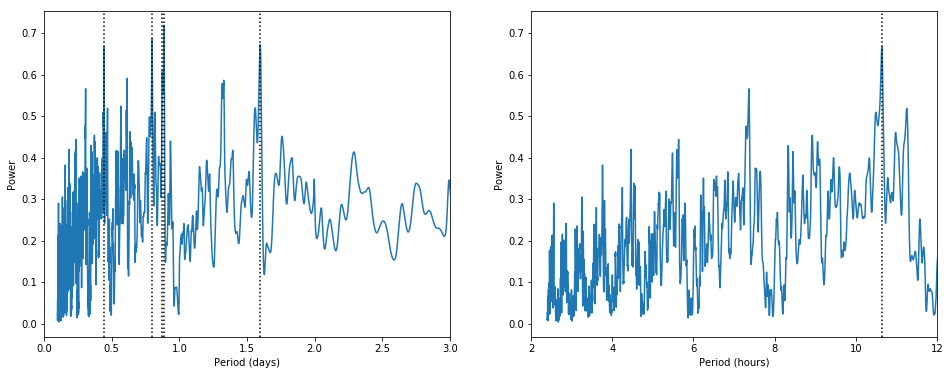

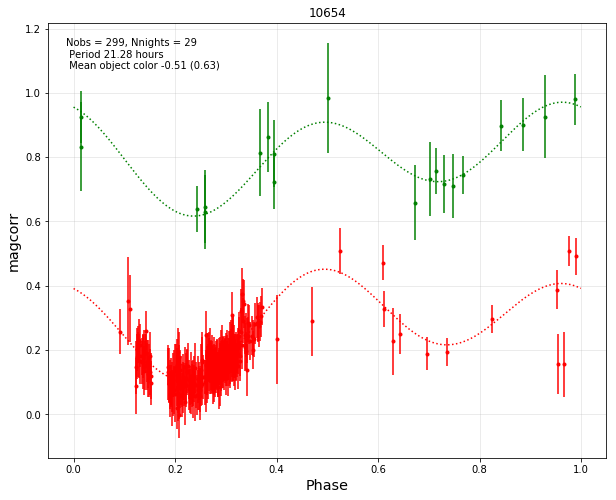

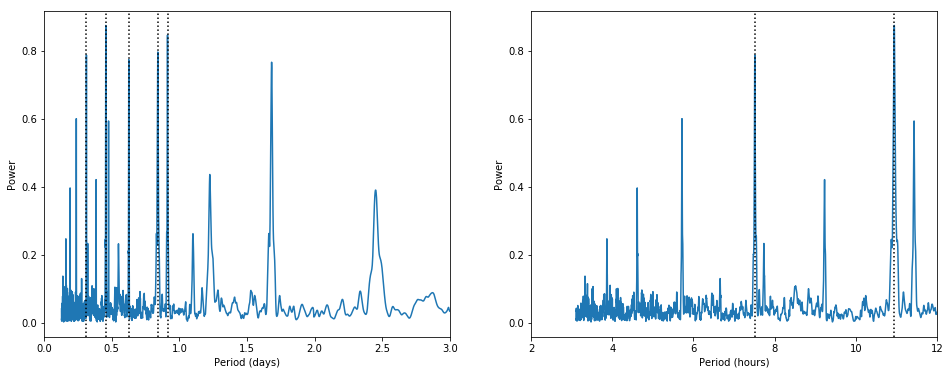

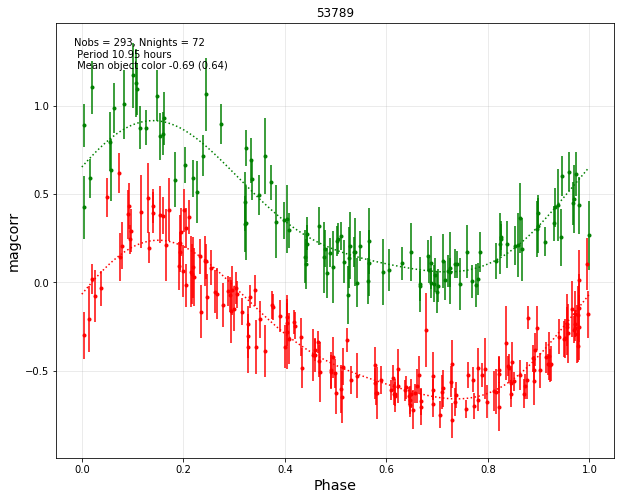

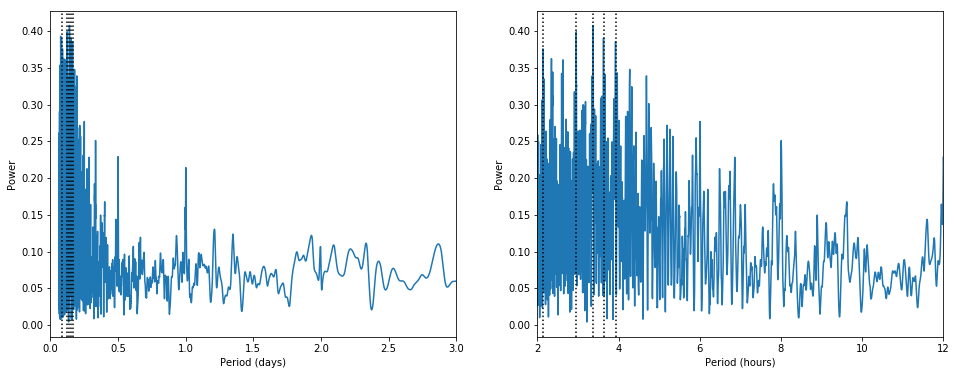

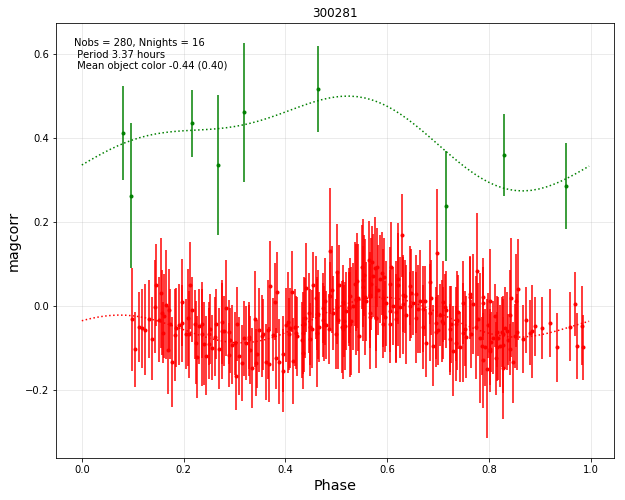

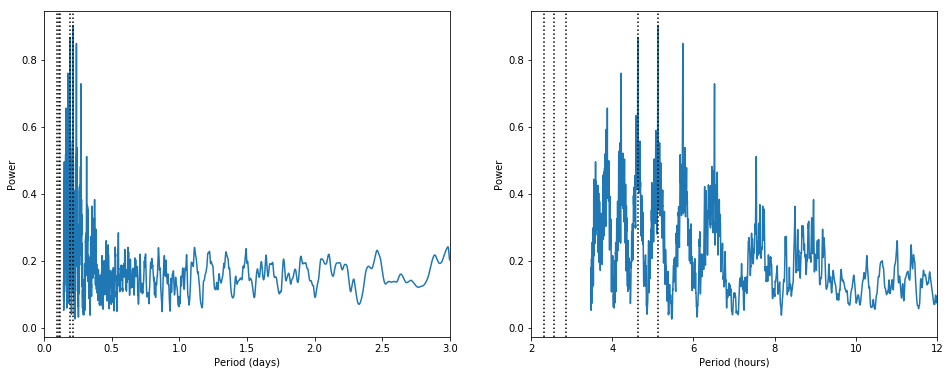

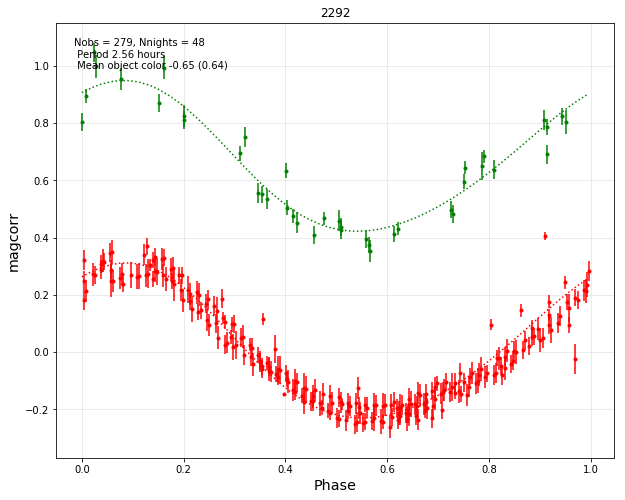

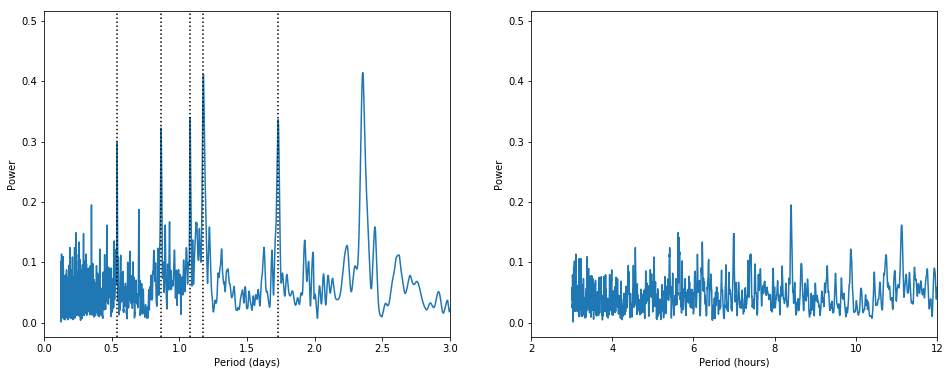

ValueError: Invalid RGBA argument: 'i'

<Figure size 720x576 with 1 Axes>

In [57]:
top_periods = {}
best_periods = {}
models = {}
periodograms = {}
phasefigures = {}
for n in objnames:
    print('Working on %s' % n)
    # Pick an object in list:
    obj, o = get_obs(n)
    models[n], top_periods[n], best_periods[n], periodograms[n] = fit_model(obj, periodogram=True)
    phasefigures[n] = plot_phased(obj, o, best_periods[n], models[n], n)

In [ ]:
for n in best_periods:
    print(n, best_periods[n]*24)

In [21]:
import sys
sys.path.extend('/data/epyc/users/lynnej/ssdpu')
import ssdpu

ModuleNotFoundError: No module named 'ssdpu'

[6.03080098 4.81696622 3.01558817 2.6781218  3.45063922]


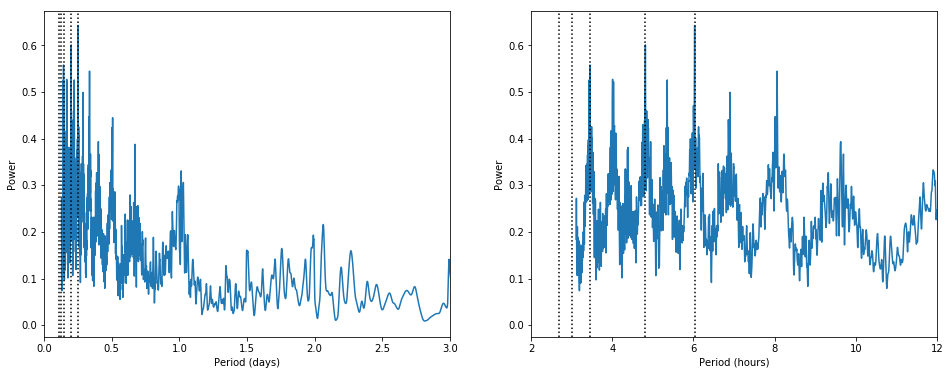

In [23]:
name = '41461'
print(top_periods[name]*24)
periodograms[name]

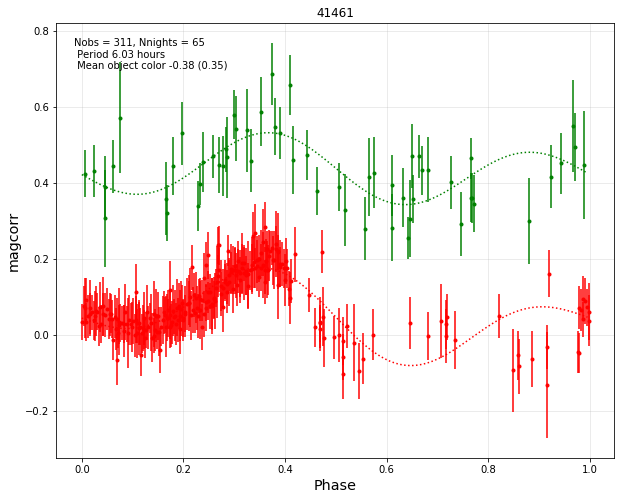

In [24]:
phasefigures[name]

In [27]:
#obj, o = get_obs(name, minJD=2.458346e+06)
obj, o = get_obs(name)
#period = best_periods[name] 
#period = 9.58656071 / 24.
#f = plot_phased(obj, o, period, models[name], name)

Filter 1 (g) has 57 observations
Filter 2 (r) has 254 observations


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [ ]:
vis_photometry(obj, o, fulldates=False).savefig(name + '_full.png')

In [28]:
o[1].magpsf.mean() - o[2].magpsf.mean(), o[1].magap.mean() - o[2].magap.mean()

(0.5509493783671893, 0.49576769581433666)

In [32]:
period = top_periods[name][0]
tfit, pred, pred2 = make_predictions(obj, period, models[name])
(pred - pred2).mean(), (pred - pred2).max(), (pred - pred2).min()

(0.3843142194762329, 0.42902308406772743, 0.3396236729553651)

In [33]:
nobs1 = len(o[1])
nobs2 = len(o[2])
print(np.sqrt(o[1].sigmagap.mean()**2/nobs1 + o[2].sigmagap.mean()**2/nobs2), 
      np.sqrt(o[1].sigmapsf.mean()**2/nobs1 + o[2].sigmapsf.mean()**2/nobs2))

0.009805024262210164 0.01145575297524202


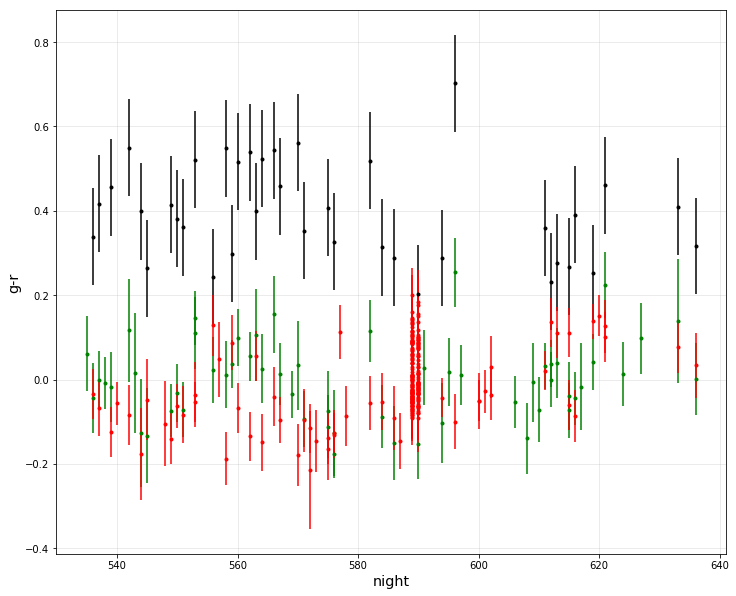

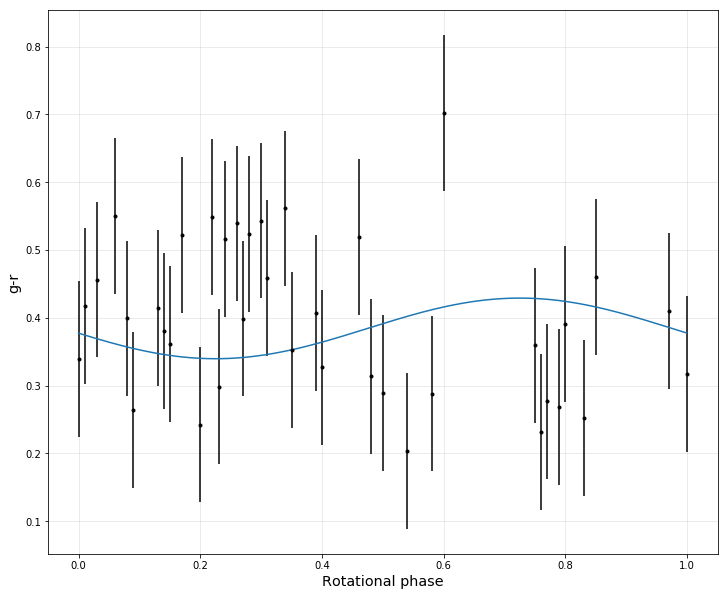

In [54]:
plt.figure(figsize=(12, 10))
# Generate predicted data, using one of the models.
model = models[name]
period =  model.best_period
step = 0.001
tfit = np.arange(0, period+step, step)
filts = np.ones(len(tfit))   
pred = model.predict(tfit, filts=filts, period=period)  # g
pred_2 = model.predict(tfit, filts=filts+1, period=period)  # r

"""
# Generate predicted data, using another of the models.
period = model2.best_period
filts = np.ones(len(tfit))   
pred2 = model2.predict(tfit, filts=filts, period=period)  # g
pred2_2 = model2.predict(tfit, filts=filts+1, period=period)  # r
"""
# 'nightly' colors
nights = []
grs = []
grerr = []
for night in obj.nid.unique():
    n = obj.query('nid == @night')
    g = n.query('fid == 1')
    r = n.query('fid == 2')
    if len(g) > 0 and len(r) > 0:
        gr = g.magpsf.median() - r.magpsf.median()
        grerr = np.sqrt(g.sigmapsf.median()**2 + r.sigmapsf.median()**2)
        nights.append(night)
        grs.append(gr)

#plt.plot(phase_times(tfit, period), pred - pred_2)
#plt.plot(tfit, pred-pred_2)
#plt.plot(phase_times(tfit, period), pred2 - pred2_2)
#plt.errorbar((nights - nights[0])/(nights[-1] - nights[0]), grs, yerr=grerr, color='k', marker='.', linestyle='')
plt.errorbar(nights, grs, yerr=grerr, color='k', marker='.', linestyle='')
plt.errorbar(o[1].nid, o[1].magcorr - o[1].magcorr.mean(), yerr=o[1].sigmapsf, color='g', marker='.', linestyle='')
plt.errorbar(o[2].nid, o[2].magcorr - o[2].magcorr.mean(), yerr=o[2].sigmapsf, color='r', marker='.', linestyle='')
plt.xlabel('night', fontsize='x-large')
plt.ylabel('g-r', fontsize='x-large')
plt.grid(True, alpha=0.3)
#plt.ylim(0.67, 0.72)

plt.figure(figsize=(12, 10))
plt.plot(phase_times(tfit, period)[:-1], (pred - pred_2)[:-1])
#plt.plot(phase_times(tfit, period), pred2 - pred2_2)
plt.errorbar((nights - nights[0])/(nights[-1] - nights[0]), grs, yerr=grerr, color='k', marker='.', linestyle='')
plt.xlabel('Rotational phase', fontsize='x-large')
plt.ylabel('g-r', fontsize='x-large')
plt.grid(True, alpha=0.3)

In [ ]:
# Pull out the list of objects with many observations, within @cutoff of the attributed sso.
cutoff = 10
large_obs = df.query('ssdistnr < @cutoff').groupby('ssnamenr')[['jd']].count()
allnames = large_obs.sort_values('jd', ascending=False)
ssnames = allnames.index.values
print(len(ssnames))
large_obs = df.query('ssdistnr < @cutoff').groupby('ssnamenr')[['jd']].count().query('jd>5')
allnames = large_obs.sort_values('jd', ascending=False)
ssnames2 = allnames.index.values
print(len(ssnames2))

In [ ]:
from numbers import Number
def expand_name(name):
    try:
        int(name)
    except ValueError:
        if name.startswith('C') or name.startswith('P'):
            name = name[0:6] + '_' + name[6:]
        else:
            year = name[0:4]
            letters = name[4:6]
            numbers = int(name[6:])
            if numbers > 0:
                name = '%s_%s%d' % (year, letters, numbers)
            else:
                name = '%s_%s' % (year, letters)
    return name

In [ ]:
convnames = []
convnames2 = []
for i in range(len(ssnames)):
    convnames.append(expand_name(ssnames[i]))
for i in range(len(ssnames2)):
    convnames2.append(expand_name(ssnames2[i]))
#convnames

In [ ]:
import sys
sys.path.extend(['/epyc/users/lynnej/ssdpu'])
import catalog_utils as cu

In [ ]:
astorb = cu.read_astorb('/epyc/users/lynnej/ssdpu/catalogs/astorb.dat')

In [ ]:
astorb[['numberId', 'designation']][0:3], astorb[['numberId', 'designation']][-3:]

In [ ]:
astfound = []
for n in convnames:
    found = astorb.query('numberId == @n')
    if len(found) == 0:
        found = astorb.query('designation == @n')
    if len(found) == 0:
        print(n, found.numberId.values, found.designation.values, len(found))
    else:
        astfound.append(found)
astfound = pd.concat(astfound)

In [ ]:
astfound2 = []
for n in convnames2:
    found = astorb.query('numberId == @n')
    if len(found) == 0:
        found = astorb.query('designation == @n')
    if len(found) == 0:
        print(n, found.numberId.values, found.designation.values, len(found))
    else:
        astfound2.append(found)
astfound2 = pd.concat(astfound2)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(astfound.a, astfound.e, 'k.', markersize=5)
plt.plot(astfound2.a, astfound2.e, 'r.', markersize=5)
plt.xlabel(r'Semimajor axis', fontsize='x-large')
plt.ylabel(r'Eccentricity', fontsize='x-large')
plt.xlim(0.25, 5.75)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(astfound.a, astfound.inc, 'k.', markersize=5)
plt.plot(astfound2.a, astfound2.inc, 'r.', markersize=5)
plt.xlabel(r'Semimajor axis', fontsize='x-large')
plt.ylabel(r'Inclination', fontsize='x-large')
plt.suptitle(r"Asteroids found in ZTF alerts", fontsize='x-large')
plt.xlim(0.25, 5.75)
plt.ylim(0, 90)
plt.grid(True, alpha=0.3)

In [ ]:
astfound.query('a > 5')[['numberId', 'designation', 'a', 'e', 'inc', 'H', 'epoch']]

In [ ]:
with open('objnames.dat', 'w') as f:
    for n in convnames:
        f.write('%s\n' % n)

In [ ]:
names